In [ ]:
https://www.kaggle.com/code/kashyapgohil/pneumonia-detection-using-cnn/notebook

https://www.kaggle.com/code/amahbubul85/cnn-classifier-using-transfer-learning/notebook

In [6]:
# Install scikeras if not already installed
!pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.7.2

Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)


# Transfer Learning (APRENDIZAJE POR TRASFERENCIA)

 Es una técnica de aprendizaje automático en la que un modelo entrenado para una tarea se reutiliza como punto de partida para un modelo en una segunda tarea relacionada.

 Este enfoque aprovecha el conocimiento ("features" y "weigths") adquirido de un conjunto de datos amplio y general para mejorar el rendimiento, ahorrar tiempo y requerir menos datos para un problema nuevo y específico.

 ### Conceptos clave
  - **Modelo preentrenado**: normalmente se trata de una arquitectura de red neuronal convolucional (CNN) grande (como ***ResNet, VGG o MobileNet***) que se ha entrenado en un conjunto de datos masivo y de propósito general como ***ImageNet*** (que contiene millones de imágenes en 1000 categorías de objetos).
  - **Transferencia de conocimiento**:
    - ***Los pesos aprendidos del modelo y las capacidades de extracción de características de la tarea inicial se transfieren a la nueva tarea***. Las primeras capas de la red suelen capturar características universales de bajo nivel, mientras que las capas posteriores se vuelven más específicas.
  - **Nueva tarea/dominio objetivo**: el modelo previamente entrenado se adapta a un problema nuevo y específico, como la clasificación de radiografías médicas para neumonía o la identificación de diferentes razas de perros.

### Enfoques comunes
  - Las dos estrategias principales para implementar el aprendizaje por transferencia son:
    - Extracción de características (***"Freezing Layers"***): Las capas convolucionales iniciales del modelo original se mantienen congeladas (sus pesos no se actualizan durante el entrenamiento) y actúan como un extractor de características fijo. Se añade una nueva capa de clasificación más pequeña y se entrena con el nuevo conjunto de datos.
    - Ajuste fino (***"Fine Tunning"***): los pesos del modelo entrenado previamente se utilizan como punto de partida, pero algunas o todas las capas se descongelan y se entrenan más (normalmente con una tasa de aprendizaje muy baja) con los datos nuevos y específicos de la tarea para adaptarlos más de cerca a los matices de la tarea de destino.

### Beneficios
  - Tiempo de capacitación reducido: evita la necesidad de una capacitación prolongada desde cero, que puede llevar días o semanas.
  - Se requieren menos datos: muy eficaz cuando se trabaja con conjuntos de datos pequeños, ya que el modelo ya posee una rica comprensión de las características visuales.
  - Rendimiento mejorado: a menudo da como resultado una mayor precisión y mejores capacidades de generalización en comparación con los modelos entrenados a partir de pesos iniciales aleatorios.
  - Menor costo computacional: requiere recursos de hardware menos potentes para entrenar el nuevo modelo.

### Tipos de aprendizaje por transferencia
  - El aprendizaje por transferencia se puede categorizar según la relación entre los dominios y tareas de origen y destino:
    - Aprendizaje por transferencia inductiva: Las tareas de origen y destino son diferentes, pero los dominios pueden ser iguales o diferentes. Esto es común cuando se utiliza un modelo de visión artificial preentrenado para una tarea de clasificación diferente.
    - Aprendizaje por Transferencia Transductiva: Las tareas de origen y destino son las mismas, pero los dominios (conjuntos de datos) son diferentes. El dominio de origen suele tener datos etiquetados, mientras que el dominio de destino suele no tenerlos.
    - Aprendizaje por transferencia no supervisada: similar a la transferencia inductiva, pero los datos etiquetados no están disponibles en los dominios de origen y destino, centrándose en cambio en tareas no supervisadas como la agrupación en clústeres.

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from scikeras.wrappers import KerasClassifier # Se requiere scikeras para usar Keras con GridSearchCV
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator # permite aumentar imágenes en tiempo real mientras el modelo se está entrenando.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ReduceLROnPlateau # permite reducir automáticamente la tasa de aprendizaje (learning rate) cuando el entrenamiento del modelo se estanca.
import cv2 # Librería de OpenCV proporciona las funciones principales para la visión artificial, permitiendo realizar operaciones de procesamiento de imágenes y video en Python.
from google.colab.patches import cv2_imshow # Para mostrar imágenes en Colab
import pickle
import os



In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def cargar_datasets(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label) # Construir la ruta de archivo completa y correcta
        class_num = labels.index(label) # Encuentra la posición numérica en "labels" y la almacena en "class_num". "Pneumonia = 0". "Normal =1"
        for img in os.listdir(path): # Toma cada imagen en el directorio
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None: # Verificar si la imagen fue cargada correctamente
                  resized_arr = cv2.resize(img_arr, (img_size, img_size))
                  data.append([resized_arr, class_num])
                else:
                    print(f"Warning: Could not read image {os.path.join(path, img)}")
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # Usar dtype=object si los elementos tienen formas diferentes, caso contrario arroja error.

In [3]:
train = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/train')

In [4]:
test = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/test')

In [5]:
val  = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/val')

In [6]:
print(type(val), type(train), type(test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
print(train)

[[array([[41, 39, 41, ..., 35, 35, 34],
         [43, 40, 38, ..., 35, 35, 34],
         [44, 40, 37, ..., 35, 35, 34],
         ...,
         [41, 46, 48, ..., 45, 48, 51],
         [42, 47, 48, ..., 46, 47, 49],
         [41, 45, 50, ..., 44, 49, 47]], dtype=uint8) 0]
 [array([[ 22,  17,  10, ...,  34,  43,  63],
         [ 18,  10,   2, ..., 104,  64,  31],
         [ 11,   5,   6, ...,  22,  74, 105],
         ...,
         [242,  13,   4, ...,   9,  14, 243],
         [  6,   6,   3, ...,   9,   9,   9],
         [  6,   6,   3, ...,   9,   9,   9]], dtype=uint8) 0]
 [array([[  1,   4, 254, ...,   0,   0,   0],
         [  1,   4, 254, ...,   0,   0,   0],
         [  1,   4, 254, ...,   0,   0,   0],
         ...,
         [  0,   0,   5, ...,   0,   0,   0],
         [  0,   0,   5, ...,   0,   0,   0],
         [  0,   0,   5, ...,   0,   0,   0]], dtype=uint8) 0]
 ...
 [array([[ 35,  24,  16, ...,   7,   7,  16],
         [ 46,  29,  17, ...,   1,   6,  26],
         [ 55,  40

In [8]:
print (train[0])

[array([[41, 39, 41, ..., 35, 35, 34],
        [43, 40, 38, ..., 35, 35, 34],
        [44, 40, 37, ..., 35, 35, 34],
        ...,
        [41, 46, 48, ..., 45, 48, 51],
        [42, 47, 48, ..., 46, 47, 49],
        [41, 45, 50, ..., 44, 49, 47]], dtype=uint8) 0]


In [9]:
print (train[0][0])

[[41 39 41 ... 35 35 34]
 [43 40 38 ... 35 35 34]
 [44 40 37 ... 35 35 34]
 ...
 [41 46 48 ... 45 48 51]
 [42 47 48 ... 46 47 49]
 [41 45 50 ... 44 49 47]]


In [10]:
print (train[0][1])

0


### Verificar el balance de los datasets
  - Revisar cuantos datos de entrenamiento y de prueba de cada clase existen.

<Axes: ylabel='count'>

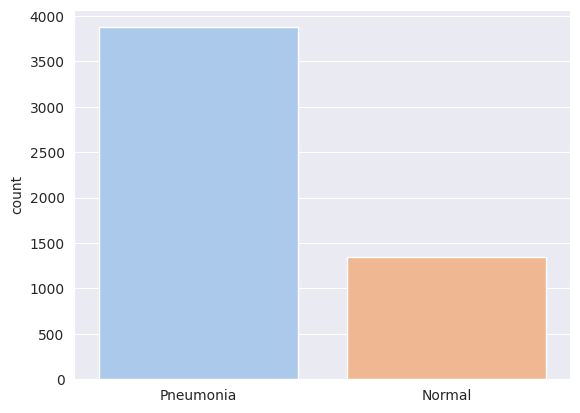

In [11]:
check_dataset_balance_train = []
for i in train:
    if(i[1] == 1):
        check_dataset_balance_train.append("Normal")
    else:
        check_dataset_balance_train.append("Pneumonia")

sns.set_style('darkgrid')
sns.set_palette('pastel')
sns.countplot(orient='v', x=check_dataset_balance_train, hue= check_dataset_balance_train )


<Axes: ylabel='count'>

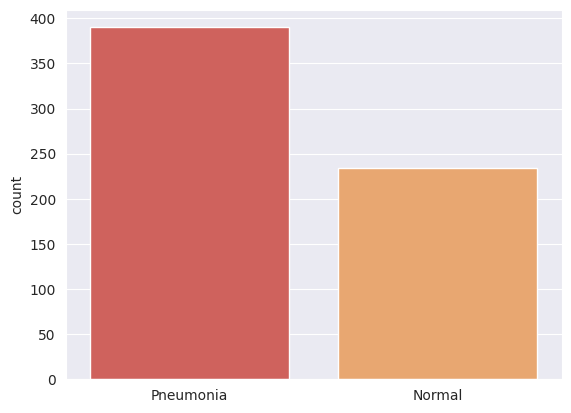

In [12]:
check_dataset_balance_test = []
for i in test:
    if(i[1] == 1):
        check_dataset_balance_test.append("Normal")
    else:
        check_dataset_balance_test.append("Pneumonia")
sns.set_style('darkgrid')
sns.set_palette('Spectral')
sns.countplot(orient='v', x=check_dataset_balance_test, hue= check_dataset_balance_test)

array([[41, 39, 41, ..., 35, 35, 34],
       [43, 40, 38, ..., 35, 35, 34],
       [44, 40, 37, ..., 35, 35, 34],
       ...,
       [41, 46, 48, ..., 45, 48, 51],
       [42, 47, 48, ..., 46, 47, 49],
       [41, 45, 50, ..., 44, 49, 47]], dtype=uint8)
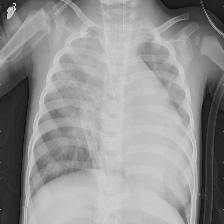

In [13]:
train[0][0]

Text(0.5, 1.0, 'NORMAL')

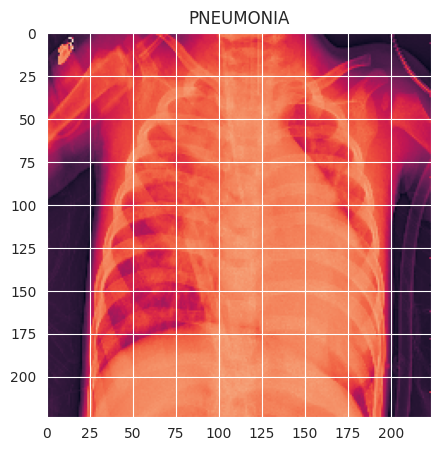

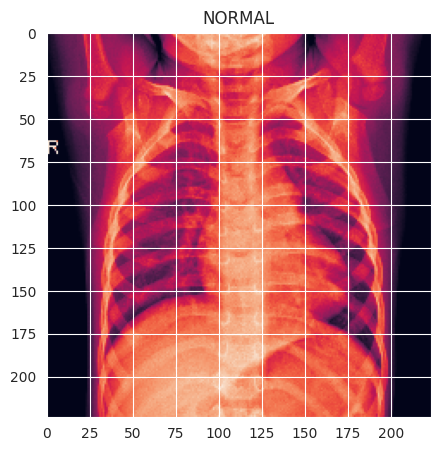

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

Text(0.5, 1.0, 'NORMAL')

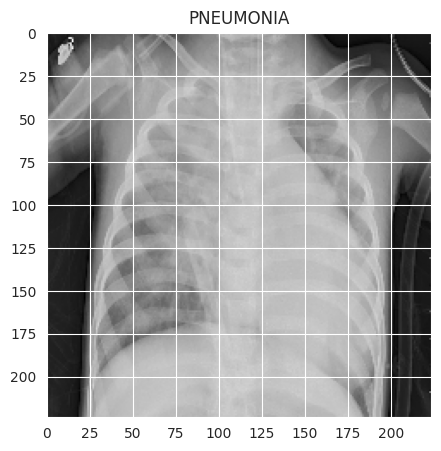

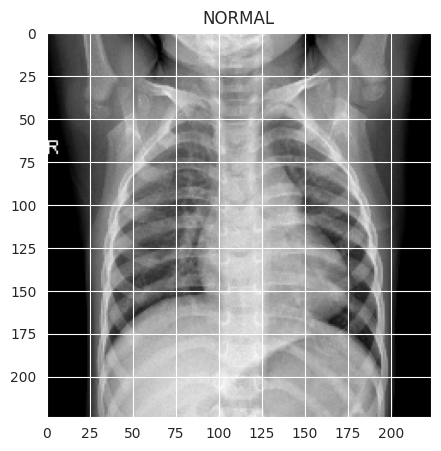

In [15]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0],cmap="gray")
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0],cmap="gray")
plt.title(labels[train[-1][1]])

In [16]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### Normalización de los datos.

#### Realicemos una normalización de la escala de grises para reducir los efectos de la diferencia de iluminación. Ademas la CNN converge mas rápido con datos entre 0 y 1 que con datos entre 0 y 255.

Esta es una práctica recomendada.

In [17]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [18]:
x_train.ndim #dimension del array (3)

3

### Preparación de los datos en el formato requerido por CNN

El arreglo x_train es reconfigurado a una nueva forma. La nueva forma es un arreglo de cuatro dimensiones. La primera dimensión es inferida automáticamente ( se expresa con el parámetro -1). La segunda y tercera dimensión corresponden al tamaño de la imagen. La cuarta dimensión es el canal de color.



In [19]:
# Reconfigurar los datos para CNN
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [20]:
x_train.ndim #array dimensionado (4)

4

### Desarrollo y entrenamiento del modelo

---

Despues de correr GridSearchCV se encontraron los mejores hiperparámetros:

  - {'batch_size': 64,
 'epochs': 5,
 'model__dropout_rate': 0.3,
 'model__filters_per_layer': 16,
 'model__num_conv_layers': 3,
 'model__optimizer': 'sgd'}

 Sin embargo, el modelo sigue mostrando "overfitting", causado por el desbalance de clases.

 ---

Para solucionar el desbalance de clases aplicamos la técnica SMOTE (Synthetic Minority Over-sampling Technique), diseñada para, precisamente, mitigar el problema del overfitting causado por el desbalance de clases.



In [21]:
from imblearn.over_sampling import SMOTE

# Redimensionar x_train para SMOTE (Para estar seguros)
n_samples = x_train.shape[0]
x_reshaped = x_train.reshape(n_samples, -1)

# Inicializar SMOTE
sampler = SMOTE(random_state=42)

# Aplicar SMOTE al set de datos de entrenamiento para crear un dataset balanceado.
x_resampled, y_resampled = sampler.fit_resample(x_reshaped, y_train)

# Redimensionar x_resampled al formato 4D requerido por CNN.

x_resampled = x_resampled.reshape(-1, img_size, img_size, 1)

# Luego, cuando se llame al "model.fit()" debemos usar `x_resampled` y `y_resampled` .`
#  `history = model.fit(x_resampled, y_resampled, ...)`

SMOTE contribuyó a mejorar sustancialmente el overfitting, balanceando las clases, pero los graficos de accuracy y loss, aun no convergen.

---

CONCLUSION:

El valor del umbral óptimo encontrado con el análisis de la curva AUC-PR es excepcionalmente bajo, lo cual sugiere que el modelo está trabajando con datos altamente desbalanceados o que la clase positiva es muy rara.

Por eso vamos a probar la técnica de Transfer Learning.

Algunas investigaciones sugieren que combinar ***transfer learning*** con técnicas de remuestreo como SMOTE puede ser eficaz para abordar el desequilibrio de datos en imágenes médicas y otros dominios, siempre que la metodología sea sólida (es decir, aplicar SMOTE solo a la parte de entrenamiento).

Aplicar data augmentation en el set de datos de entrenamiento es altamente recomendable.

---

## Transfer Learning

### Cómo funciona
  - En lugar de entrenar un modelo desde cero con pesos inicializados aleatoriamente, el aprendizaje por transferencia implica los siguientes pasos:
    - Seleccionar un modelo previamente entrenado: elejir un modelo que ya haya sido entrenado en un conjunto de datos grande y general.
    - Capas de reutilización y congelación: Las capas iniciales de una red neuronal suelen aprender características generales como bordes, formas y texturas. Estas capas se conservan y, a menudo, sus pesos se congelan (se mantienen fijos) para preservar el conocimiento fundamental adquirido durante el entrenamiento inicial.
    - Agregar nuevas capas: las capas finales originales, específicas de la tarea, se eliminan y se reemplazan con capas nuevas y entrenables adaptadas a la nueva tarea de destino (por ejemplo, cambiar de una salida de 1000 clases a una salida de 2 clases).
    - Entrenamiento/Ajuste: El modelo se entrena con el nuevo conjunto de datos específico del objetivo. Inicialmente, solo se entrenarán las nuevas capas. Posteriormente, para un mejor rendimiento, algunas de las capas superiores del modelo base, previamente congeladas, se pueden "descongelar" y ajustar con una tasa de aprendizaje baja para adaptarlas mejor a los nuevos datos, sin sobrescribir el aprendizaje básico genérico.

Los modelos para el aprendizaje por transferencia están disponibles a través de varias plataformas y frameworks.

Se puede encontrar una amplia variedad de modelos preentrenados en las siguientes plataformas:
  - TensorFlow Hub (TF Hub): Este repositorio ofrece numerosos módulos reutilizables de aprendizaje automático, incluyendo modelos para tareas de imagen, texto y audio. Están diseñados para integrarse fácilmente en los flujos de trabajo de TensorFlow y Keras.
  - PyTorch Hub: similar a TF Hub, esta plataforma proporciona modelos previamente entrenados que se pueden descubrir y publicar para los usuarios de PyTorch.
  - Hugging Face Hub: Esta vasta plataforma comunitaria, especialmente destacada en el procesamiento del lenguaje natural (PLN) y, cada vez más, en la visión artificial, alberga miles de modelos y conjuntos de datos fácilmente accesibles a través de su biblioteca.
  - Model Zoos (Official Repositories): las principales instituciones de investigación y empresas tecnológicas suelen publicar sus modelos de vanguardia en "Model Zoos" oficiales (por ejemplo, aquellos asociados con artículos académicos o marcos específicos como detectron2 o MMDetection).

  ---


ImageDataGenerator

In [ ]:
# 1. Convertir imagenes 1 canal a imagenes de 3 canales, requerido por ResNet152v2
x_res = np.repeat(x_resampled, 3, axis=-1)
x_val_res = np.repeat(x_val, 3, axis=-1)


# 2. Inicializar el ImageDataGenerator con parámetros de aumento.
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 3. Usar el método .flow() para crear un generador
batch_size = 32
train_generator = datagen.flow(
    x_res,
    y_resampled,
    batch_size=batch_size,
    shuffle=True # Shuffle data every epoch
)

Callbacks

In [3]:
#Setting callbakcs


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

Vamos a seleccionar el modelo ResNet152V2, disponible en el paquete Keras. https://keras.io/api/applications/

Este modelo fue previamente entrenado en otro dataset (ImageNet), especialiado en clasificación de imágenes.

Seteamos el parámetro "include_top" a false, lo que deshabilita "head", responsable de la asignación de clases. Mantenemos todas las capas previas. Luego incorporamos nuestras capas, incluyendo la responsable de la generación de la clasificación.

Head = conjunto de capas finales que toman las características extraídas de las capas previas y producen el resultado final.


In [27]:
# 1. Definir el modelo base (sin incluir la capa final de clasificación)
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False) # Muy importante
# 2. Congelar el modelo base (para no reentrenar sus pesos)
base_model.trainable = False # Muy importante congela los pesos del modelo preentrenado,impide que se modifiquen durante el entrenamiento posterior.


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
def get_pretrained():
    # 3. Procesar las entradas y obtener las características en 'x'
    # (features) extraídas de los datos de entrada (inputs) por el modelo base pre-entrenado (base_model).
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs)

    # 4. Añadir capas propias personalizadas (el "head")
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation='sigmoid')(x) #Final Layer (Output)

    # 5. Crear el modelo completo
    model = keras.Model(inputs=[inputs], outputs=output)

    return model

x contendrá la salida del último bloque convolucional de la red, devuelto como un tensor 4D de mapas de características .

Contenido de x
  - Tipo: x es un tensor TensorFlow (o tensor Keras/tensor simbólico, dependiendo de cómo inputs se haya definido).
  - Forma: La forma de x será (batch_size, height, width, channels). Los valores exactos de height, width, y channels dependen del tamaño de la imagen de entrada y de la arquitectura interna de ResNet152V2.
    - La dimensión del canal será un número grande (probablemente 2048 para ResNet152V2).
    - Las dimensiones de altura y anchura se reducirán con respecto al tamaño original de la imagen de entrada mediante diversas operaciones de agrupación y convolución. Por ejemplo, con un tamaño de entrada común de (150, 150, 1), la forma de salida x probablemente será de aproximadamente (batch_size, 7, 7, 2048).
  - Datos: ***Los valores del tensor son las características aprendidas (o "mapas de características") extraídas por la red ResNet152V2 preentrenada a partir de las imágenes de entrada***. Estas características representan patrones visuales genéricos (bordes, texturas, formas, etc.) aprendidos del conjunto de datos ImageNet.

  x = layers.GlobalAveragePooling2D()(x) toma los mapas de características espacialmente ricos generados por la base convolucional preentrenada (x), realiza una operación de agrupación de promedios globales para condensar estas características en un vector de tamaño fijo y, a continuación, asigna este nuevo vector de características condensado a x. Este x está listo para conectarse a capas de clasificación personalizadas (p. ej., keras.layers.Dense) para su tarea específica de aprendizaje por transferencia.


In [30]:
# Limpia el estado interno de Keras y libera memoria
keras.backend.clear_session()
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [ ]:
BATCH = 32

# Convert 1-channel images to 3-channel for ResNet152V2
x_resampled_3_channel = np.repeat(x_resampled, 3, axis=-1)
x_val_3_channel = np.repeat(x_val, 3, axis=-1)

# Update train_generator to use the 3-channel data
datagen_3_channel = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator_3_channel = datagen_3_channel.flow(
    x_resampled_3_channel,
    y_resampled,
    batch_size=batch_size,
    shuffle=True
)

history = model_pretrained.fit(train_generator_3_channel,
          batch_size = BATCH, epochs = 50,
          validation_data=(x_val_3_channel, y_val),
          callbacks=[early_stopping, plateau],
          steps_per_epoch=len(train_generator_3_channel),
          validation_steps=int(np.ceil(len(x_val_3_channel)/BATCH)))